In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

num_layers = 3 # newly added in this tutorials
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15 
state_size = 4
num_classes = 2
echo_step = 3 
batch_size = 5 # number of sample trained in a iteration
num_batches = total_series_length//batch_size//truncated_backprop_length

In [2]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)


In [3]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])


# Please refers to 
# https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/LSTMStateTuple
# cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
# hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
# init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)
# print("init_state created by LSTMStateTuple:", init_state)

# the aboved code is commented out because we are going to replace the init_state as 
# following
init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

# Since the TF Multilayer-LSTM-API accepts the states as a tuple of LSTMTuples, 
# we need to first unstack the state, then there will be num_layers of 
# tensor in shape of [2, batch_size, state_size] 
state_per_layer_list = tf.unstack(init_state, axis=0) 
# Then, transform the state_per_layer_list into a list of LSTMStateTuple
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(
            state_per_layer_list[idx][0], 
            state_per_layer_list[idx][1])
     for idx in range(num_layers)
    ]
)

rnn_tuple_state

(LSTMStateTuple(c=<tf.Tensor 'strided_slice:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'strided_slice_1:0' shape=(5, 4) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'strided_slice_2:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'strided_slice_3:0' shape=(5, 4) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'strided_slice_4:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'strided_slice_5:0' shape=(5, 4) dtype=float32>))

In [4]:
# W and b is useless in this example, because the tensorflow will create the 
# weight for the variable in the cell.
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1, state_size)), dtype=tf.float32)


# W2 and b2 is needed as we will use this to calculate the logits of the outputs
W2 = tf.Variable(np.random.rand(state_size, num_classes), dtype=tf.float32)
b2 = tf.Variable(np.zeros((1, num_classes)), dtype=tf.float32)

In [5]:
# batchX_placeholder is in shape of (batch_size, truncated_backprop_length)
# Let's say batch_size=5, and truncated_backprop_length=15
# If we unstack the batchX_placeholder, it will have 15 of (5,) tensor.
# The rnn is trained based on this 5 batches with 15 timesteps each

# inputs_series = tf.unstack(batchX_placeholder, axis=1)
# ^ the above code is replaced by tf.split command
# tf.split will split the batchX_placeholder evenly into truncated_backprop_length
# number of tensor along the 1st-axis
# e.g. batchX_placeholder is of shape (5, 30) and truncated_backprop_length is 3
# then, there will be 10 tensors of shape (5, 3)
inputs_series = tf.split(batchX_placeholder, 15, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

print(inputs_series)

[<tf.Tensor 'split:0' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:10' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:11' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:12' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:13' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:14' shape=(5, 1) dtype=float32>]


In [6]:
# This is basically the forward pass in the RNN.
# For each input in the inputs_series, we concatenate it with the state value.
# Then, we apply the same weights W and biases b on each of these input and
# find the corresponding state value in this time series. 

if False: # for reference only
    current_state = init_state
    states_series = []

    for current_input in inputs_series:
        # (5,) -> (5,1) so as to concatenate with the state
        current_input = tf.reshape(current_input, [batch_size, 1])

        # Calculate the sum of affine transform
        # By concatenating those two tensors you will only use one matrix 
        # multiplication.
        input_and_state_concatenated = tf.concat([current_input, current_state], 1)

        next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)
        states_series.append(next_state)
        current_state = next_state

In [7]:
# forward pass implemented with the help of tensorflow
# This code resembles the above 
# cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

# used for single layer
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size, state_is_tuple=True)
# states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)


# used for multi-layer
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, 
                                                       inputs_series, 
                                                       initial_state=rnn_tuple_state)


In [8]:
# each layer will return a state, therefore there will be 3 cell_states and hidden_states
# Thus, in each timestep, the rnn will return 3 tuples of LSTM cell state.
print(current_state)

# The state_series will return only the last layer of the LSTM 
print (states_series)

(LSTMStateTuple(c=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_0/basic_lstm_cell/add_1:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_0/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_1/basic_lstm_cell/add_1:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_1/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_2/basic_lstm_cell/add_1:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'rnn/multi_rnn_cell_14/cell_2/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>))
[<tf.Tensor 'rnn/multi_rnn_cell/cell_2/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/multi_rnn_cell_1/cell_2/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/multi_rnn_cell_2/cell_2/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/multi_rnn_cell_3/cell_2/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=floa

In [9]:
# Calculating loss

# This calculate the logits of the series X fed intp the rnn by multiplying
# the hidden state neurons with weights and adding the biases. If the truncated
# length is of 15, then the length of logits series is also of 15.
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)\
         for logits, labels in zip(logits_series, labels_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [10]:
# visualizing the training

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = \
        np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = \
        np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

New data, epoch 0
Step 0 Loss 0.693052
Step 100 Loss 0.684805
Step 200 Loss 0.578267
Step 300 Loss 0.478715
Step 400 Loss 0.330643
Step 500 Loss 0.0281259
Step 600 Loss 0.00912669
New data, epoch 1
Step 0 Loss 0.55962
Step 100 Loss 0.00524076
Step 200 Loss 0.00378288
Step 300 Loss 0.0030171
Step 400 Loss 0.00230438
Step 500 Loss 0.00232687
Step 600 Loss 0.00183346
New data, epoch 2
Step 0 Loss 0.524574
Step 100 Loss 0.00159937
Step 200 Loss 0.00155124
Step 300 Loss 0.00104901
Step 400 Loss 0.00123688
Step 500 Loss 0.00123167
Step 600 Loss 0.00129611
New data, epoch 3
Step 0 Loss 0.3745
Step 100 Loss 0.000696863
Step 200 Loss 0.00083152
Step 300 Loss 0.000495405
Step 400 Loss 0.000502525
Step 500 Loss 0.000583262
Step 600 Loss 0.000623307
New data, epoch 4
Step 0 Loss 0.896701
Step 100 Loss 0.000567448
Step 200 Loss 0.000773069
Step 300 Loss 0.000507078
Step 400 Loss 0.00060116
Step 500 Loss 0.000587442
Step 600 Loss 0.000575203
New data, epoch 5
Step 0 Loss 0.633691
Step 100 Loss 0.000

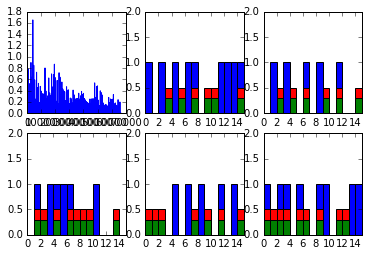

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list=[]
    
    for epoch_idx in range(num_epochs):
        x,y = generateData()
        # _current_cell_state = np.zeros((batch_size, state_size))
        # _current_hidden_state = np.zeros((batch_size, state_size))
        # The following _current_state is defined for the multi-layered LSTM
        # It defines as followed:
        # (1) the number of layers we have in the RNN model, within each layers,
        # (2) there are 2 states - cell_state and hidden_state
        # (3) Each state will simultaneously consider batch_size of input, and 
        # (4) the number of units of the state is of state_size
        _current_state = np.zeros((num_layers, 2, batch_size, state_size))
        
        print("New data, epoch", epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = \
            sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                }
            )
            
            # current_state is a tuple of (cell_state, hidden_state)
            # _current_cell_state, _current_hidden_state = _current_state
            
            
            loss_list.append(_total_loss)
            
            if batch_idx%100 == 0:
                print("Step",batch_idx,"Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

In [ ]:
current_input = inputs_series[0]
current_input = tf.reshape(current_input, [batch_size, 1])
current_state = init_state
tf.concat([current_input, current_state], 1)